# Index

### 1. Importing Libraries
### 2. Evaluation Metric Definition
### 3. Importing Data
### 4. Data Preprocessing
### 5. Feature Engineering
### 6. Baseliner
### 7. Modelling
### 8. Evaluation
### 9. Submission
### 10. What did not Work

### Importing Libraries

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import os

%matplotlib inline

plt.rcParams['figure.figsize'] = [15, 8]
plt.style.use("fivethirtyeight")

import warnings
warnings.simplefilter('ignore')

pd.options.display.max_rows = 500
pd.options.display.max_columns = 500

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score, train_test_split, TimeSeriesSplit
from sklearn.metrics import make_scorer, mean_squared_error

# Regression
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet, Lasso
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor, BaggingRegressor, ExtraTreesRegressor, GradientBoostingRegressor, RandomForestRegressor, VotingRegressor

import xgboost as xgb
import lightgbm as lgb
import catboost as cat

### Evaluation Metric

In [41]:
def metric(y, y0):
    assert len(y) == len(y0)
    return 100 - np.sqrt(np.mean(np.power(np.log1p(y)-np.log1p(y0), 2)))

def metric_lgb(y_pred, data):
    y_true = data.get_label()
    result = metric(y_true, y_pred)

    return '100-rmse', result, True # third parameter in greater_is_better

### Importing Data

In [125]:
train_1 = pd.read_csv("../../data/train.csv")
test_1 = pd.read_csv("../../data/test.csv")
sub = pd.read_csv("../../data/sample_submission.csv")

print("Train Shape : {}\nTest Shape: {}\nSub Shape: {}".format(train_1.shape, test_1.shape, sub.shape))

Train Shape : (33750, 15)
Test Shape: (14454, 14)
Sub Shape: (14454, 2)


In [126]:
train = train_1.copy()
test = test_1.copy()

In [127]:
train.head()

,date_time,is_holiday,air_pollution_index,humidity,wind_speed,wind_direction,visibility_in_miles,dew_point,temperature,rain_p_h,snow_p_h,clouds_all,weather_type,weather_description,traffic_volume
0,2012-10-02 09:00:00,None,121,89,2,329,1,1,288.28,0.0,0.0,40,Clouds,scattered clouds,5545
1,2012-10-02 10:00:00,None,178,67,3,330,1,1,289.36,0.0,0.0,75,Clouds,broken clouds,4516
2,2012-10-02 11:00:00,None,113,66,3,329,2,2,289.58,0.0,0.0,90,Clouds,overcast clouds,4767
3,2012-10-02 12:00:00,None,20,66,3,329,5,5,290.13,0.0,0.0,90,Clouds,overcast clouds,5026
4,2012-10-02 13:00:00,None,281,65,3,329,7,7,291.14,0.0,0.0,75,Clouds,broken clouds,4918


#### In our EDA notebook we observed that we had several duplicate time-indexed records. Lets check them

In [128]:
train[train.duplicated(subset=['date_time'])].head()

,date_time,is_holiday,air_pollution_index,humidity,wind_speed,wind_direction,visibility_in_miles,dew_point,temperature,rain_p_h,snow_p_h,clouds_all,weather_type,weather_description,traffic_volume
179,2012-10-10 07:00:00,None,69,23,3,220,3,3,281.25,0.0,0.0,99,Drizzle,light intensity drizzle,6793
181,2012-10-10 08:00:00,None,82,33,3,150,7,7,280.10,0.0,0.0,99,Drizzle,light intensity drizzle,6283
183,2012-10-10 09:00:00,None,188,36,3,170,6,6,279.61,0.0,0.0,99,Drizzle,light intensity drizzle,5680
270,2012-10-14 09:00:00,None,132,37,5,350,8,8,282.43,0.0,0.0,57,Mist,mist,2685
271,2012-10-14 09:00:00,None,285,26,7,330,7,7,282.43,0.0,0.0,57,Haze,haze,2685


In [129]:
train[['date_time', 'traffic_volume']][train.duplicated(subset=['date_time'])].head()

,date_time,traffic_volume
179,2012-10-10 07:00:00,6793
181,2012-10-10 08:00:00,6283
183,2012-10-10 09:00:00,5680
270,2012-10-14 09:00:00,2685
271,2012-10-14 09:00:00,2685


#### Here we can see that just the features change for the duplicate time-indexed records but the traffic_volume (target) remains the same. 

#### So the better approach would be to drop all the duplicate time-indexed values and at the time of submission just substitute for the duplicate time-indexes in test set. 

## Data Preprocessing

### Duplicate Time-Indexes

In [130]:
target = 'traffic_volume'

duplicate_train_idx = train[train.duplicated(['date_time', 'traffic_volume'], keep='first')].index
duplicate_test_idx = test[test.duplicated(['date_time'], keep='first')].index
train.drop(duplicate_train_idx, axis=0, inplace=True)
test.drop(duplicate_test_idx, axis=0, inplace=True)
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)
test[target] = np.nan

print("New Train Shape : {}\nNew Test Shape : {}".format(train.shape, test.shape))

New Train Shape : (28589, 15)
New Test Shape : (11986, 15)


In [131]:
print("We have {} duplicates in Train Set and {} in Test set.".format(33750 - 28589, 14454 - 11986))

We have 5161 duplicates in Train Set and 2468 in Test set.


## Feature Engineering

In [132]:
train_len = train.shape[0]
data = pd.concat([train, test], ignore_index=True)
print(data.shape)

(40575, 15)


### Date-Time Features

In [133]:
def create_time_feats(df, col, drop=False):
    # Extracting date features

    df[col + '_day_hr'] = df[col].dt.hour
    df[col + '_day_month'] = df[col].dt.day
    df[col + '_day_year'] = df[col].dt.dayofyear
    df[col + '_day_week'] = df[col].dt.dayofweek
    df[col + '_month'] = df[col].dt.month
    df[col + '_year'] = df[col].dt.year
    df[col + '_week_year'] = df[col].dt.weekofyear
    df[col + '_is_month_end'] = (df[col].dt.is_month_end).astype(int)
    df[col + '_is_week_end'] = ((df[col + '_day_week']) // 5 == 1).astype(float)
    
    if drop:
        df.drop([col], axis=1, inplace=True)
    return df

In [134]:
data['date_time'] = pd.to_datetime(data['date_time'], format="%Y-%m-%d %H:%M:%S")
data = create_time_feats(data, 'date_time', False)

#### To give a Temporal sense as this is a time-series problem I encode the date_time in a way to make the model understand the effect for time and date.

In [135]:
le = LabelEncoder()
data['date_time'] = le.fit_transform(data[['date_time']])
print(len(le.classes_))

40575


### Target Mean Encoding - Did not work

In [136]:
def target_mean_encoding(data, col, target):
    agg = data.groupby([col])[target].mean().sort_values(ascending=False).reset_index()
    agg = agg.to_dict()
    agg = dict((v,k) for k,v in agg[col].items())
    data[col] = data[col].apply(lambda x: agg[x])
    
    return data

In [137]:
# for col in data.select_dtypes('object').columns:
#     data = target_mean_encoding(data, col, target)

### Label Encoding

In [138]:
le_1 = LabelEncoder()
for col in data.select_dtypes('object').columns:
    data[col] = le_1.fit_transform(data[[col]])

In [139]:
train = data.iloc[:train_len]
test = data.iloc[train_len:]

print("New Train Shape : {}\nNew Test Shape : {}".format(train.shape, test.shape))

New Train Shape : (28589, 24)
New Test Shape : (11986, 24)


In [140]:
test.reset_index(drop=True, inplace=True)
feat = train.columns.tolist()
feat.remove(target)
print("Feature Length : {}".format(len(feat)))

Feature Length : 23


### Train-Validation Split

- As this is a time-series problem setting shuffle=False and taking 20% of the train set as validation would suffice.

In [141]:
trainX, validX = train_test_split(train, test_size=0.2, shuffle=False, random_state=13)
print("Train Shape : {}\nValid Shape : {}".format(trainX.shape, validX.shape))

Train Shape : (22871, 24)
Valid Shape : (5718, 24)


### Baseliner

In [142]:
def baseliner(train, features, target, cv=3, metric=make_scorer(metric, True)):
    print("Baseliner Models(All)")
    eval_dict = {}
    models = [
        KNeighborsRegressor(), GaussianNB(), 
        lgb.LGBMRegressor(), ExtraTreesRegressor(), xgb.XGBRegressor(objective='reg:squarederror'), 
        cat.CatBoostRegressor(verbose=0), GradientBoostingRegressor(), RandomForestRegressor(), 
        LinearRegression(), DecisionTreeRegressor(), ExtraTreeRegressor(), AdaBoostRegressor(), 
        BaggingRegressor(), ElasticNet(), Lasso(), Ridge(), 
        ] #SVR(), 

    print("sklearn Model Name  \t  CV")
    print("--" * 50)

    for index, model in enumerate(models, 0):
        model_name = str(model).split("(")[0]
        eval_dict[model_name] = {}

        results = cross_val_score(model, train[features], train[target], cv=cv, scoring=metric)
        eval_dict[model_name]['cv'] = results.mean()

        print("%s \t %.4f \t" % (
            model_name[:21], eval_dict[model_name]['cv']))

### Cross - Validation Type - WalkForward Split

In [143]:
tscv = TimeSeriesSplit(n_splits=3)

In [144]:
baseliner(train, feat, target, cv=tscv, metric=make_scorer(metric, True))

Baseliner Models(All)
sklearn Model Name  	  CV
----------------------------------------------------------------------------------------------------
KNeighborsRegressor 	 98.8491 	
GaussianNB 	 99.1536 	
LGBMRegressor 	 99.6851 	
ExtraTreesRegressor 	 99.6896 	
XGBRegressor 	 99.5605 	
<catboost.core.CatBoo 	 99.6721 	
GradientBoostingRegre 	 99.4628 	
RandomForestRegressor 	 99.6822 	
LinearRegression 	 99.0113 	
DecisionTreeRegressor 	 99.5397 	
ExtraTreeRegressor 	 99.6158 	
AdaBoostRegressor 	 99.5768 	
BaggingRegressor 	 99.6837 	
ElasticNet 	 99.1053 	
Lasso 	 99.1140 	
Ridge 	 99.1052 	


### Some good-performing models are : 
1. LightGBM
2. ExtraTreesRegressor
3. BaggingRegressor
4. RandomForestRegressor
5. CatBoost

### LightGBM

In [52]:
def lgb_model(train, features, target, ts=False, plot=True):
    evals_result = {}
    trainX, validX, trainY, validY = train_test_split(train[features], train[target], shuffle=False, test_size=0.2, random_state=13)
    print("LGB Model")
    lgb_train_set = lgb.Dataset(trainX, label=trainY)
    lgb_valid_set = lgb.Dataset(validX, label=validY)

    MAX_ROUNDS = 1111
    lgb_params = {
        "boosting": 'dart',
        "learning_rate": 0.1,
        "nthread": -1,
        "seed": 13,
        "num_boost_round": MAX_ROUNDS,
        "objective": "regression",
    }

    lgb_model = lgb.train(
        lgb_params,
        train_set=lgb_train_set,
        valid_sets=[lgb_train_set, lgb_valid_set],
        early_stopping_rounds=250,
        verbose_eval=100,
        evals_result=evals_result,
        feval=metric_lgb # New metric to be optimised
    )
    if plot:
        lgb.plot_importance(lgb_model, figsize=(24, 24))
        lgb.plot_metric(evals_result, metric='100-rmse')

    return lgb_model, lgb_model.best_score

LGB Model
[100]	training's l2: 451570	training's 100-rmse: 99.6655	valid_1's l2: 620019	valid_1's 100-rmse: 99.7394
[200]	training's l2: 249262	training's 100-rmse: 99.698	valid_1's l2: 382729	valid_1's 100-rmse: 99.7928
[300]	training's l2: 143075	training's 100-rmse: 99.7186	valid_1's l2: 307763	valid_1's 100-rmse: 99.8079
[400]	training's l2: 104174	training's 100-rmse: 99.7294	valid_1's l2: 260941	valid_1's 100-rmse: 99.8153
[500]	training's l2: 91389.8	training's 100-rmse: 99.7358	valid_1's l2: 264777	valid_1's 100-rmse: 99.8132
[600]	training's l2: 76712.8	training's 100-rmse: 99.741	valid_1's l2: 244271	valid_1's 100-rmse: 99.816
[700]	training's l2: 78416.6	training's 100-rmse: 99.7428	valid_1's l2: 257597	valid_1's 100-rmse: 99.8155
[800]	training's l2: 70751.9	training's 100-rmse: 99.7451	valid_1's l2: 253734	valid_1's 100-rmse: 99.8144
[900]	training's l2: 62033	training's 100-rmse: 99.7535	valid_1's l2: 272374	valid_1's 100-rmse: 99.8122
[1000]	training's l2: 58243.9	traini

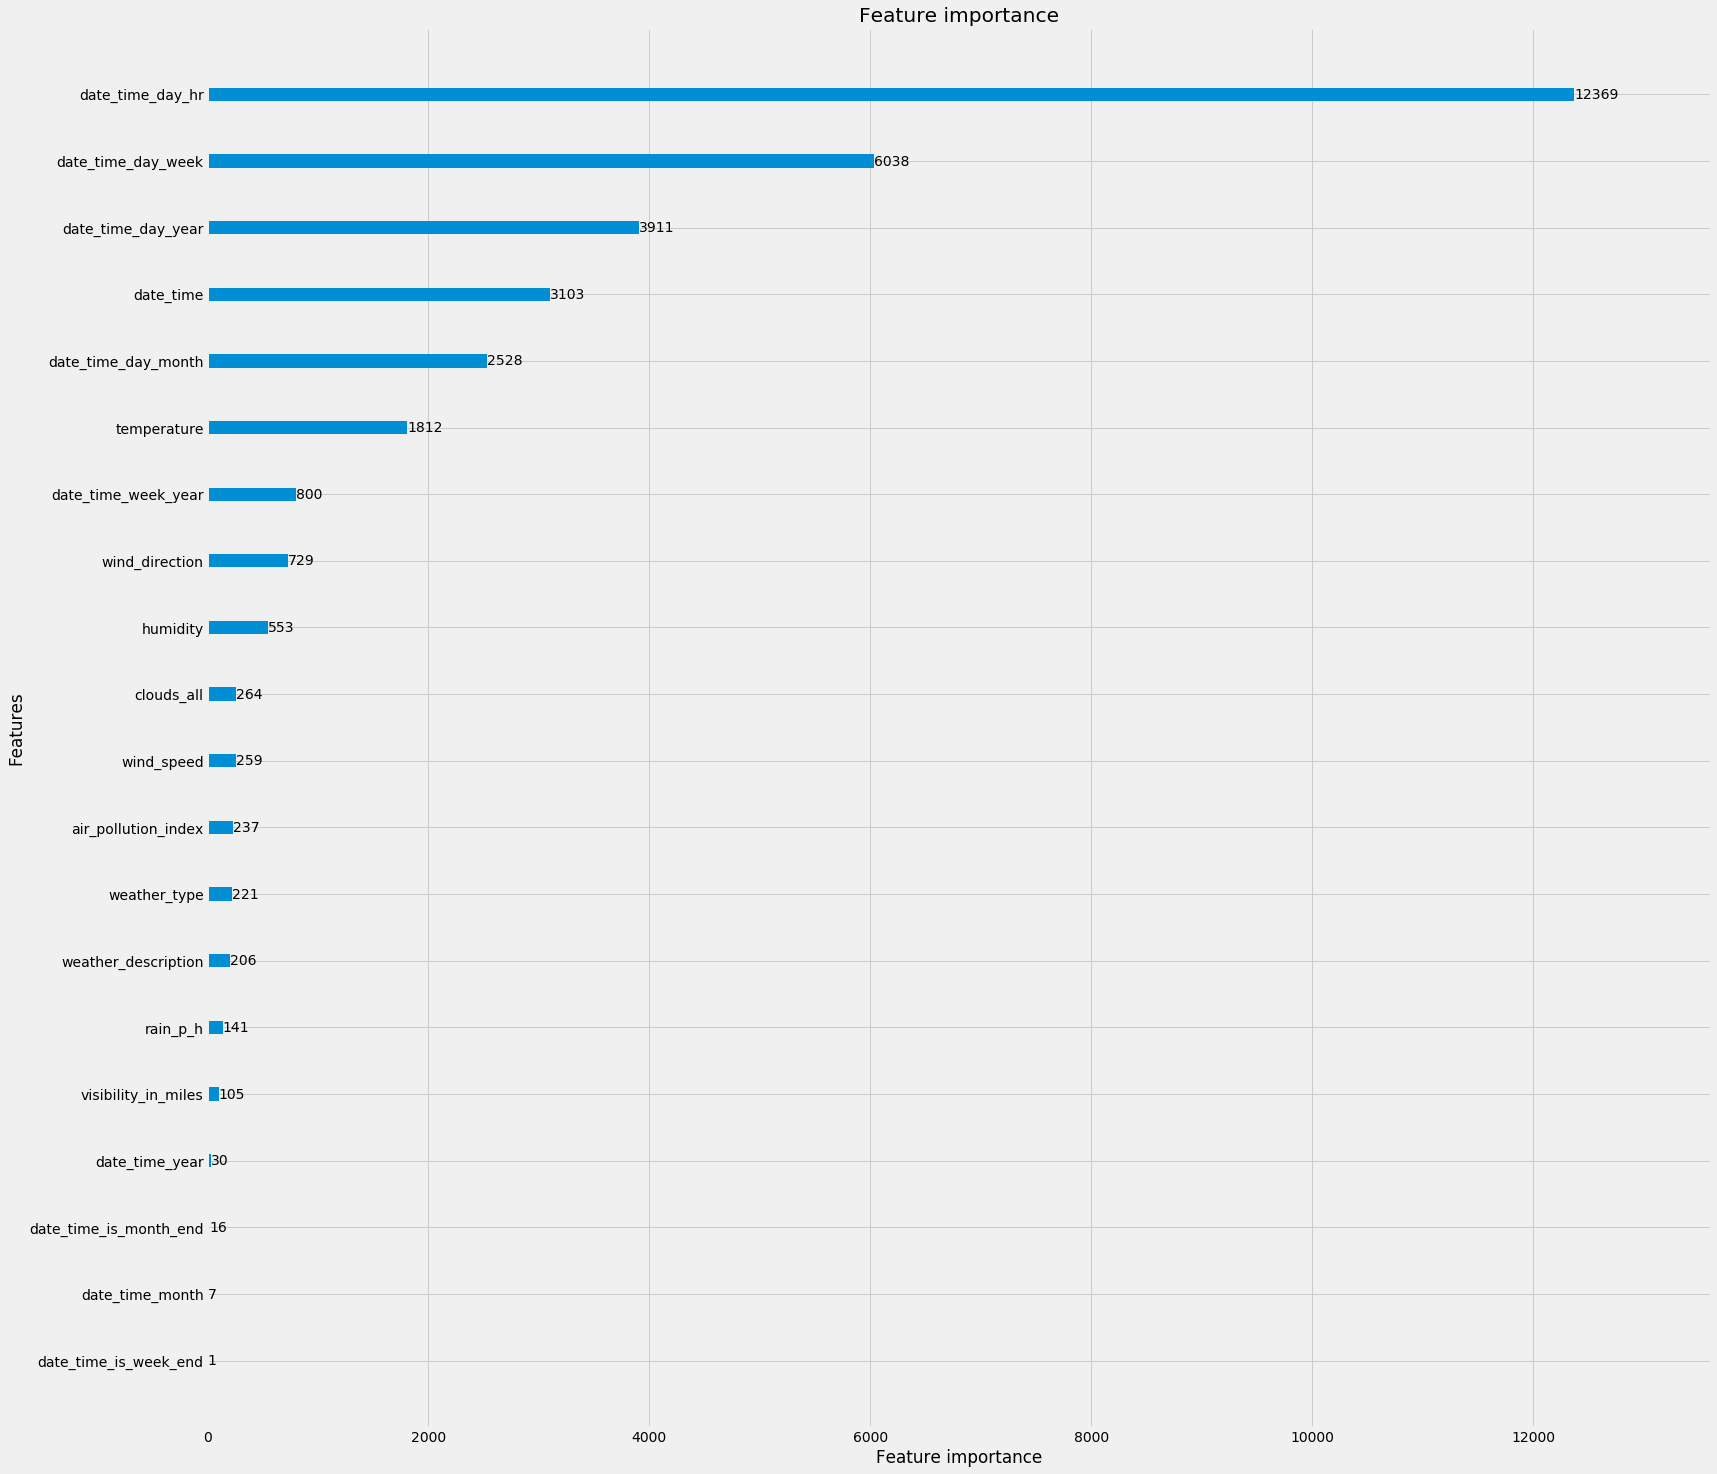

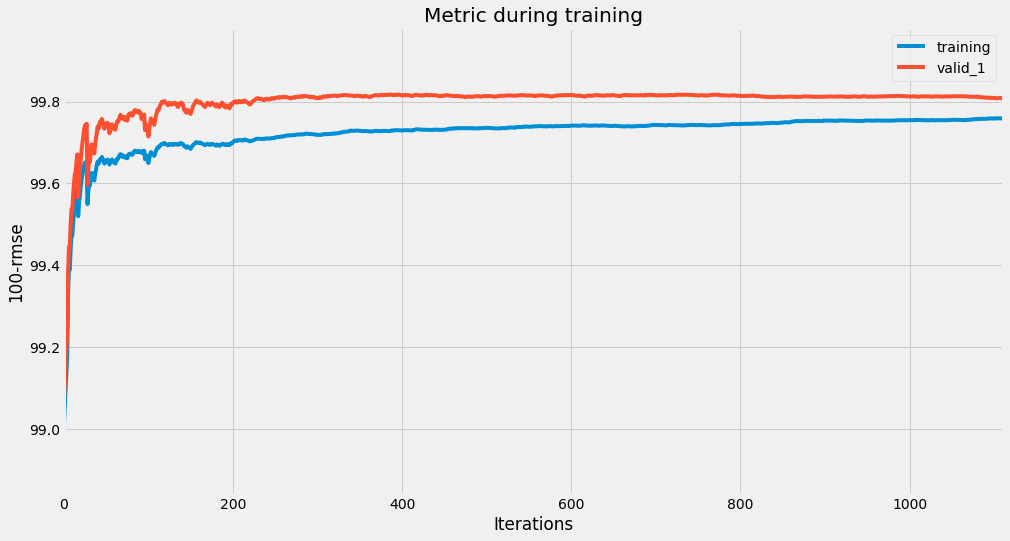

In [53]:
lgbM, score = lgb_model(train, feat, target, True, True)

## Visualising the Predictions

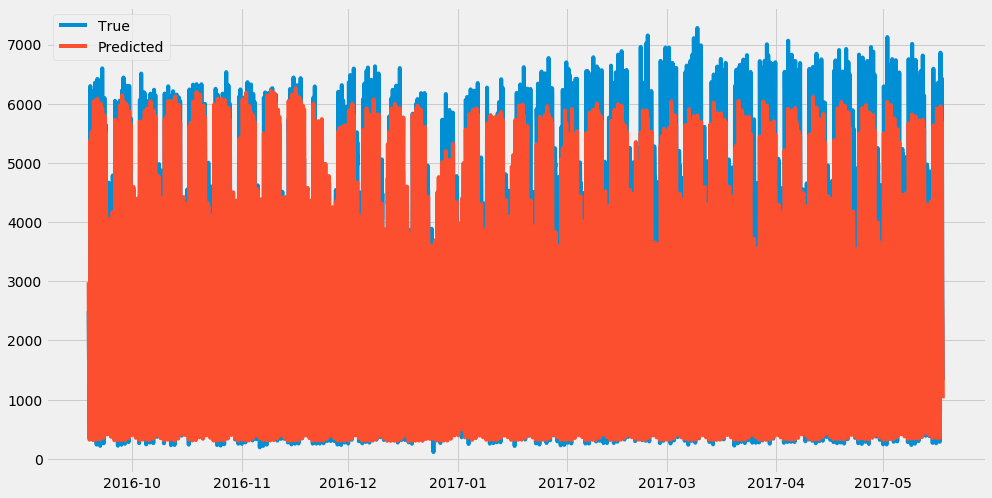

In [55]:
y_preds = lgbM.predict(validX[feat])

plt.figure()
plt.plot(le.inverse_transform(validX['date_time']), validX[target], label='True')
plt.plot(le.inverse_transform(validX['date_time']), y_preds, label='Predicted')

plt.legend(loc='best')
plt.show()

### Detailed Visualising

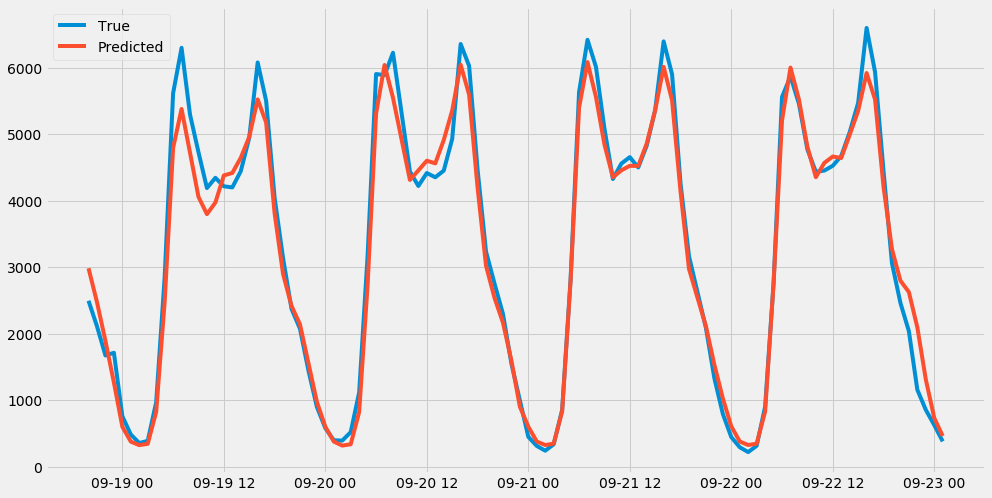

In [56]:
plt.figure()
plt.plot(le.inverse_transform(validX['date_time'].iloc[: 100]), validX[target].iloc[: 100], label='True')
plt.plot(le.inverse_transform(validX['date_time'].iloc[: 100]), y_preds[:100], label='Predicted')

plt.legend(loc='best')
plt.show()

#### Looks good.

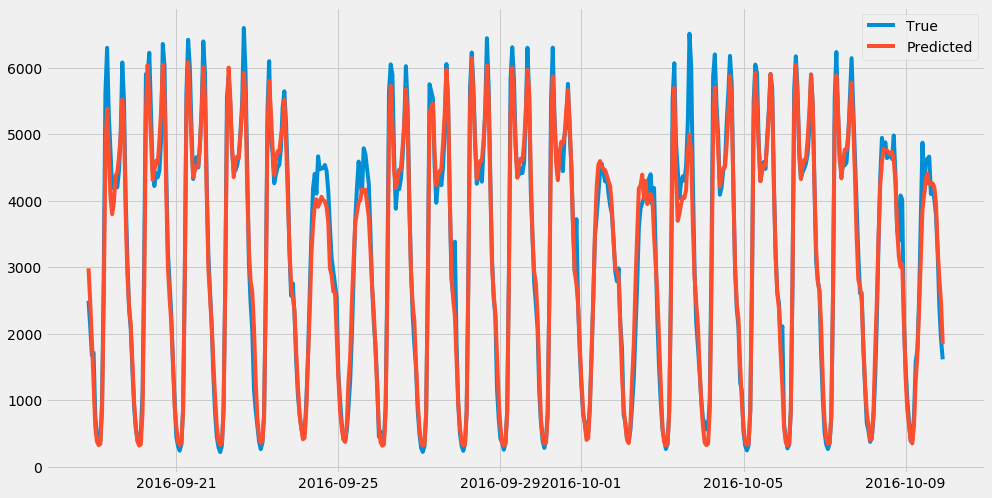

In [57]:
plt.figure()
plt.plot(le.inverse_transform(validX['date_time'].iloc[: 500]), validX[target].iloc[: 500], label='True')
plt.plot(le.inverse_transform(validX['date_time'].iloc[: 500]), y_preds[:500], label='Predicted')

plt.legend(loc='best')
plt.show()

### By observing we can see that the model is not able to capture spikes in the traffic_volume . 

### Training on FULL Data

In [145]:
lgtrain = lgb.Dataset(train[feat], label=train[target])

In [146]:
MAX_ROUNDS = 1111
lgb_params = {
    "boosting": 'dart',
    "learning_rate": 0.1,
    "nthread": -1,
    "seed": 13,
    "num_boost_round": MAX_ROUNDS,
    "objective": "regression",
    'min_split_gain': 0,
}

In [147]:
lgb_model = lgb.train(
    lgb_params,
    train_set=lgtrain,
    verbose_eval=100,
    feval=metric_lgb, # New metric to be optimised
)

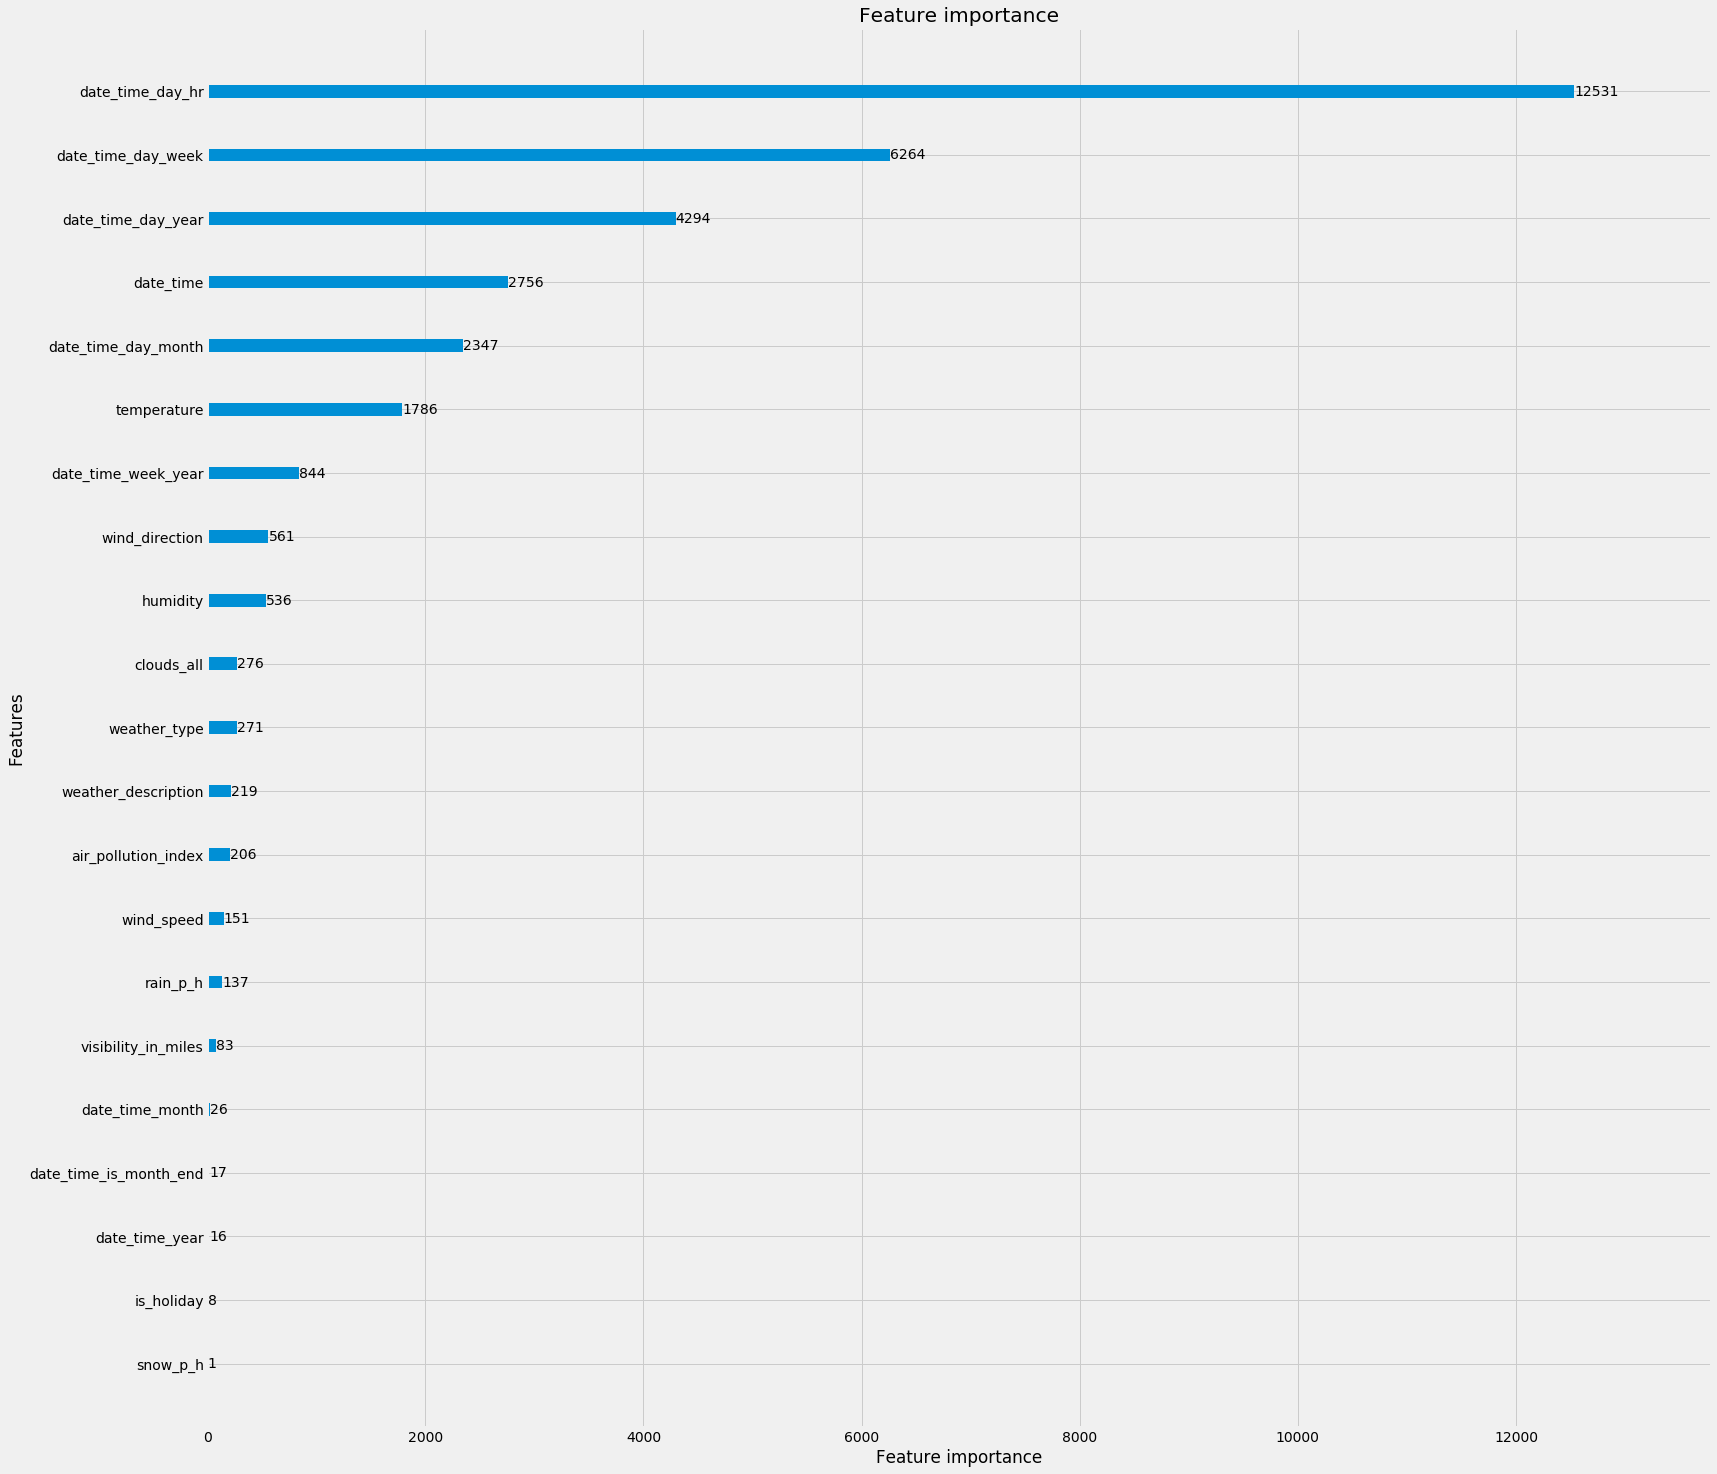

In [148]:
lgb.plot_importance(lgb_model, figsize=(24, 24))

### Prediction

In [149]:
test[target] = np.nan
y_preds = lgb_model.predict(test[feat])
test[target] = y_preds
test[target].head()

0    775.670914
1    400.663871
2    348.720899
3    363.217915
4    822.441380
Name: traffic_volume, dtype: float64

### As these predictions are for non-duplicate time-indexes, let's merge this predictions for duplicate time-indexes to make the final submission file.

In [150]:
test['date_time'] = le.inverse_transform(test[['date_time']])
test['date_time'] = test['date_time'].astype(str)
sub = pd.merge(sub, test[['date_time', target]], on='date_time', how='left')
test['date_time'] = pd.to_datetime(test['date_time'], format="%Y-%m-%d %H:%M:%S")
test['date_time'] = le.transform(test[['date_time']])
sub.drop([target + '_x'], axis=1, inplace=True)
sub.columns = ['date_time', target]
sub.head()

,date_time,traffic_volume
0,2017-05-18 00:00:00,775.670914
1,2017-05-18 00:00:00,775.670914
2,2017-05-18 00:00:00,775.670914
3,2017-05-18 01:00:00,400.663871
4,2017-05-18 01:00:00,400.663871


In [151]:
sub.to_csv("../../subs/new/lgb_final_1.csv", index=False)

# Single LGB Model : (Performed Best both on LB and CV)

### Local Cross-Validation : 99.8087
### Public Leaderboard : 99.97637 -- Rank 19

### Ensembling the below models too decresed the performance of final score. So only Single Model LGB is used for final submission

In [68]:
# Fitting Two More Models that we saw perform good in Baseliner
extM = ExtraTreesRegressor(n_estimators=300, max_depth=11, n_jobs=-1, random_state=13)
bagM = BaggingRegressor(base_estimator=ExtraTreesRegressor(), n_estimators=50, n_jobs=-1, random_state=13)

extM.fit(train[feat], train[target])
bagM.fit(train[feat], train[target])

ext_preds = extM.predict(test[feat])
bag_preds = bagM.predict(test[feat])

test[target] = ext_preds
test['date_time'] = le.inverse_transform(test[['date_time']])
test['date_time'] = test['date_time'].astype(str)
sub = pd.merge(sub, test[['date_time', target]], on='date_time', how='left')
test['date_time'] = pd.to_datetime(test['date_time'], format="%Y-%m-%d %H:%M:%S")
test['date_time'] = le.transform(test[['date_time']])
sub.drop([target + '_x'], axis=1, inplace=True)
sub.columns = ['date_time', target]
sub.to_csv("../../subs/new/ext_final_1.csv", index=False)

test[target] = bag_preds
test['date_time'] = le.inverse_transform(test[['date_time']])
test['date_time'] = test['date_time'].astype(str)
sub = pd.merge(sub, test[['date_time', target]], on='date_time', how='left')
test['date_time'] = pd.to_datetime(test['date_time'], format="%Y-%m-%d %H:%M:%S")
test['date_time'] = le.transform(test[['date_time']])
sub.drop([target + '_x'], axis=1, inplace=True)
sub.columns = ['date_time', target]
sub.to_csv("../../subs/new/bag_final_1.csv", index=False)

# What did not work : 

1. Log-Transform Target
1. Target Mean Encoding
1. Features : 
    - Lag Features
    - Rolling Mean Features
    - Cyclic Time Features (Cos, Sin)
    - Target Mean aggregate features
    - Binned features for clouds_all, air_pollution_index
1. XGB
1. Ensembling and Stacking had negligable effect against Single LGB Model.